# Notebook Exploration

## Functions

In [13]:
import nltk
import re
from bs4 import BeautifulSoup
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    text = lowercase_text(text)
    text = remove_urls(text)
    # Tokenization
    word_tokens = tokenization(text)
    word_tokens = clear_ponctuation(word_tokens)
    # custom clean
    word_tokens = custom_clean(word_tokens)
    # Lemmatisation
    lemmatized_words = lemmatization(word_tokens)
    # Suppression des stopwords
    return remove_stopwords(lemmatized_words)

def remove_urls(text):
    regex = r'https?://\S+|www\.\S+'
    text = re.sub(regex, '', text)
    return text

def custom_clean(text):
    # remplacer les sauts de lignes par des espaces
    word_tokens = [word_token.replace('\n', ' ') for word_token in text]
    # supprimer les espaces en trop
    word_tokens = [re.sub(r'\s+', ' ', phrase) for phrase in word_tokens]
    return word_tokens
    
def lowercase_text(text):
    return text.lower()

def tokenization(text):
    return sent_tokenize(text)

def lemmatization(word_tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in word_tokens]

def lemmatize_and_flatten(phrases):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for phrase in phrases for word in ' '.join(phrase).split()]

def remove_stopwords(sentences):
    stop_words = set(stopwords.words('english'))
    result = []
    for sentence in sentences:
        words = sentence.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        result.append(' '.join(filtered_words))
    return result

def clear_ponctuation(text):
    return [re.sub(r'[^a-zA-Z0-9\s]', '', phrase) for phrase in text]

def extract_text_from_body(html_body):
    soup = BeautifulSoup(html_body, 'html.parser')
    return soup.get_text()

def transform_tags(tags_string):
    # Utiliser une expression régulière pour extraire les tags entre '<' et '>'
    tags = re.findall(r'<(.*?)>', tags_string)
    # Joindre les tags avec des virgules pour obtenir une chaîne
    cleaned_tags = ','.join(tags)
    return cleaned_tags

# Exemple de tâche d'apprentissage machine
def train_and_evaluate(data):
    # Chargez les données
    X = data.drop('tags', axis=1)
    y = data['tags']

    # Divisez les données en ensemble d'entraînement et ensemble de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialisation de MLflow
    mlflow.start_run()

    # Paramètres
    param_max_depth = 10
    param_n_estimators = 100

    # Enregistrez les paramètres
    mlflow.log_param("max_depth", param_max_depth)
    mlflow.log_param("n_estimators", param_n_estimators)

    # Créez et entraînez le modèle
    model = RandomForestClassifier(max_depth=param_max_depth, n_estimators=param_n_estimators)
    model.fit(X_train, y_train)

    # Faites des prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calculez et enregistrez la métrique
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    # Enregistrez le modèle
    mlflow.sklearn.log_model(model, "model")

    # Enregistrez un fichier artefact (par exemple, un fichier texte)
    with open("artifact.txt", "w") as artifact_file:
        artifact_file.write("Contenu de l'artefact")

    mlflow.log_artifact("artifact.txt")

    # Fin de l'expérience MLflow
    mlflow.end_run()


## Récupération des données 

In [14]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("dataset.csv")
data.columns = data.columns.str.lower()

# Garder seulement 100% des données
percent_to_keep = 1
data_subset = data.sample(frac=percent_to_keep, random_state=42)

print(len(data_subset))

# Afficher les premières lignes du nouveau sous-ensemble
print(data_subset.head())

# Enregistrer le nouveau sous-ensemble dans un nouveau fichier CSV si nécessaire
data_subset.to_csv("dataset_subset.csv", index=False)


45362
                                                   title  \
17851                 How to catch exception in flutter?   
19108  SSL_ERROR_SSL(1): operation failed within the ...   
39835  Why can the type constraint `std::convertible_...   
21813  Groupby Pandas DataFrame and calculate mean an...   
31621  How to prevent downtime during AWS Elastic Bea...   

                                                    body creationdate  score  \
17851  <p>This is my exception class. Exception class...   2018-10-09     49   
19108  <p>I am getting some <code>SSL Error</code>s (...   2018-08-18     46   
39835  <p>I've scrolled and searched through <a href=...   2021-08-23     23   
21813  <p>I have a Pandas DataFrame as below:</p>\n<p...   2014-10-28     40   
31621  <p>My understanding of <a href="http://aws.ama...   2012-07-16     29   

                                                    tags  
17851  <flutter><dart><exception><model-view-controll...  
19108        <ios><swift><alamofir

## Supression des balises HTML avec BeautifulSoup

In [15]:
data_subset['body'] = data_subset['body'].apply(extract_text_from_body)

## Reformatage des tags pour remplacer les chevrons par des virgules

In [16]:
data_subset['tags_transformed'] = data_subset['tags'].apply(transform_tags)

## Tokenization and Lemmatization with Stopword Removal on Title et Body

In [17]:
data_subset['title_lemmatized'] = data_subset['title'].apply(preprocess_text)
data_subset['body_lemmatized'] = data_subset['body'].apply(preprocess_text)

In [18]:
data_subset.to_csv("dataset_transformed.csv", index=False)

## Sauvegarder les données nettoyées

In [19]:
columns_to_keep = ['title_lemmatized', 'body_lemmatized', 'tags_transformed', 'creationdate']
subset_to_save = data_subset[columns_to_keep]
subset_to_save.to_csv("dataset_cleaned.csv", index=False)

## Nuage de mots

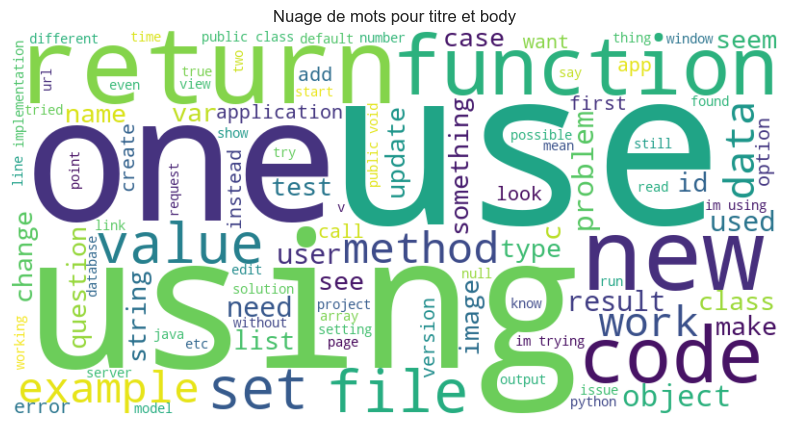

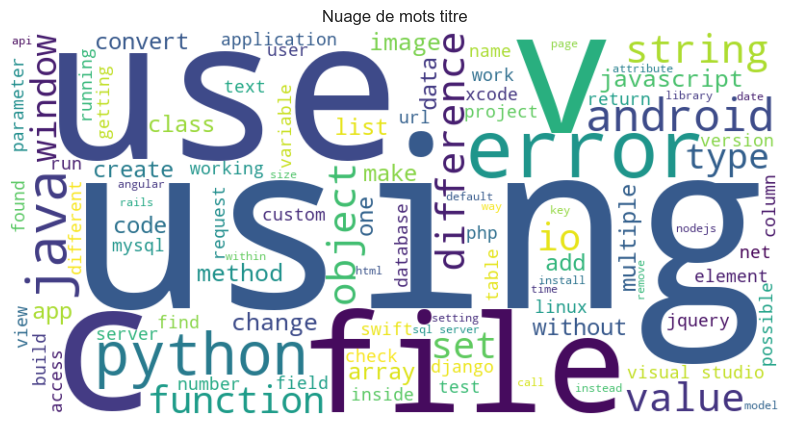

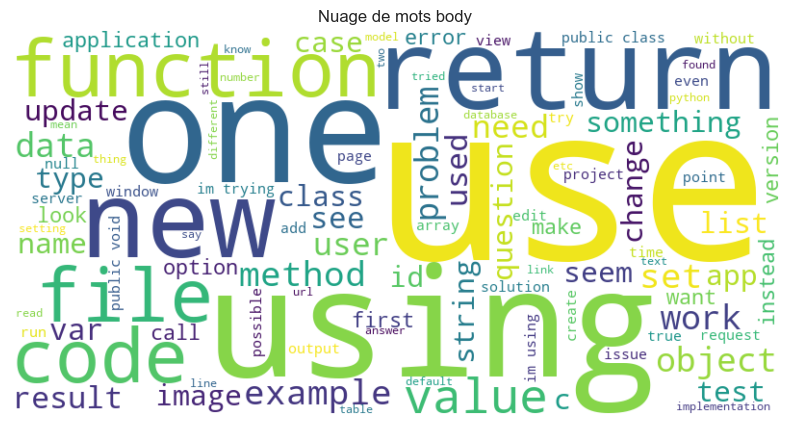

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = [word for words_list in subset_to_save['title_lemmatized'] + subset_to_save['body_lemmatized'] for word in words_list]

title_words = [word for words_list in subset_to_save['title_lemmatized'] for word in words_list]

body_words = [word for words_list in subset_to_save['body_lemmatized'] for word in words_list]

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(all_words))

title_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(title_words))

body_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(body_words))

plt.figure(num=1, figsize=(10, 5))
plt.title('Nuage de mots pour titre et body')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('nuage_de_mots.png')
plt.show()
plt.close('all')

plt.figure(num=2, figsize=(10, 5))
plt.title('Nuage de mots titre')
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('nuage_de_mots_titre.png')
plt.show()
plt.close('all')

plt.figure(num=3, figsize=(10, 5))
plt.title('Nuage de mots body')
plt.imshow(body_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('nuage_de_mots_body.png')
plt.show()
plt.close('all')

## Graph outlier words

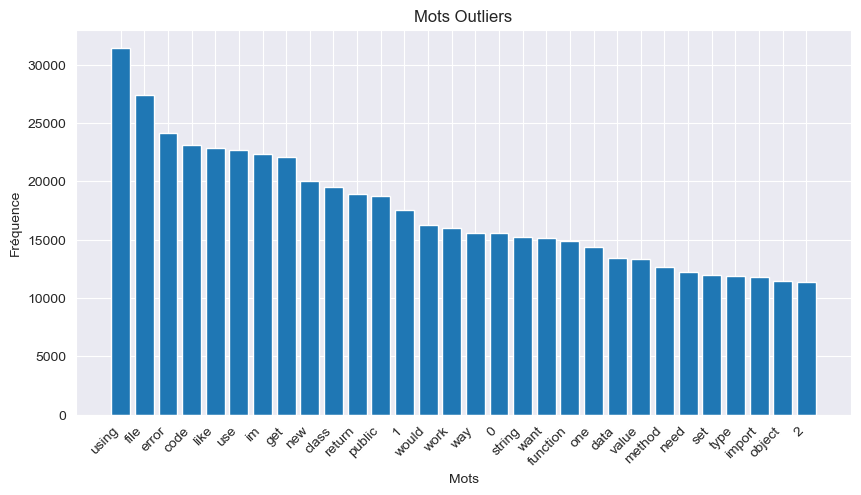

In [21]:
from collections import Counter, OrderedDict

nltk_stopwords = set(stopwords.words('english'))

title_and_body_lemmatized = subset_to_save['title_lemmatized'] + subset_to_save['body_lemmatized']
all_words = lemmatize_and_flatten(title_and_body_lemmatized)
all_words_without_stopwords = [word for word in all_words if word.lower() not in nltk_stopwords]

word_freq = Counter(all_words_without_stopwords)
outliers = [word for word, freq in word_freq.items()]
word_freq_ordered = OrderedDict(word_freq)
sorted_outliers = sorted(outliers, key=lambda word: word_freq_ordered[word], reverse=True)
top_outliers = sorted_outliers[:30]
plt.figure(figsize=(10, 5))
plt.bar(top_outliers, [word_freq[word] for word in top_outliers])
plt.title('Mots Outliers')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')
plt.show()

## CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

# Convertir les listes de phrases en phrase
title_sentence = [' '.join(words) for words in subset_to_save['title_lemmatized']]
body_sentence = [' '.join(words) for words in subset_to_save['body_lemmatized']]

print(title_sentence[:2])
vectorizer_title = CountVectorizer()
X_title = vectorizer_title.fit_transform(title_sentence)

vectorizer_body = CountVectorizer()
X_body = vectorizer_body.fit_transform(body_sentence)

print("Noms des features pour le titre:", vectorizer_title.get_feature_names_out())
print("Noms des features pour le corps:", vectorizer_body.get_feature_names_out())

print("Vecteurs pour le titre:")
print(X_title.toarray())

print(X_title.shape)

print("Vecteurs pour le corps:")
print(X_body.toarray())

## Tf-idf

import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load("en_core_web_sm")

tfidf_vectorizer_title = TfidfVectorizer()
X_title_train_tfidf = tfidf_vectorizer_title.fit_transform(train_data['title_lemmatized'])

X_title_test_tfidf = tfidf_vectorizer_title.transform(test_data['title_lemmatized'])

tfidf_vectorizer_body = TfidfVectorizer()
X_body_train_tfidf = tfidf_vectorizer_body.fit_transform(train_data['body_lemmatized'])

X_body_test_tfidf = tfidf_vectorizer_body.transform(test_data['body_lemmatized'])

feature_names_title = tfidf_vectorizer_title.get_feature_names_out()
print("Caractéristiques (mots) apprises par le vectorizer pour 'title':")
print(feature_names_title)

print("Matrice TF-IDF pour 'title' dans l'ensemble d'entraînement:")
print(X_title_train_tfidf.toarray())

print("Matrice TF-IDF pour 'title' dans l'ensemble de test:")
print(X_title_test_tfidf.toarray())

feature_names_body = tfidf_vectorizer_body.get_feature_names_out()
print("Caractéristiques (mots) apprises par le vectorizer pour 'body':")
print(feature_names_body)

print("Matrice TF-IDF pour 'body' dans l'ensemble d'entraînement:")
print(X_body_train_tfidf.toarray())

print("Matrice TF-IDF pour 'body' dans l'ensemble de test:")
print(X_body_test_tfidf.toarray())


In [22]:
# Exécutez la tâche d'apprentissage machine avec le chemin de votre jeu de données
# train_and_evaluate(data)